# HW3 Q3 - Data Compression using Tucker Truncation and Hard Thresholding

In [1]:
import pandas as pd
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly import partial_svd
from numpy.linalg import norm
from tensorly.decomposition import tucker

In [2]:
# Import data
att = spio.loadmat('ATT-2.mat',squeeze_me=True)['A'].astype(np.float64)

### Part A
**Write your own code for Tucker decomposition using ALS algorithm.**   

X = G $x_1$ A $x_2$ B $x_3$ C  
$X \in R^{56x46x20}, G \in R^{30x20x20}$

In [3]:
R1 = 30
R2 = 30
R3 = 20
n1 = 56
n2 = 46
n3 = 20

In [4]:
# Initialize A, B, C
A = np.random.randn(n1, R1)
B = np.random.randn(n2, R2)
C = np.random.randn(n3, R3)

for k in range(0,20):

    ################# Solve for A ########################
    
    # Project tensor X on to basis B and C
    X_proj = tl.tenalg.multi_mode_dot(att, [B.T, C.T], [1,2])
       
    # Unfold X_proj into mode 1 matriciziation 
    X_proj1 = tl.unfold(X_proj, 0).astype(np.float64)
    
    # Compute SVDS for A
    A, S, V = partial_svd(X_proj1, R1)  
                   
    ################# Solve for B ########################
    
    # Project tensor X on to basis A and C
    X_proj = tl.tenalg.multi_mode_dot(att, [A.T, C.T], [0,2])
    
    # Unfold X_proj into mode 2 matriciziation 
    X_proj1 = tl.unfold(X_proj, 1).astype(np.float64)
    
    # Compute SVDS for B
    B, S, V = partial_svd(X_proj1, R2)  
    
    ################# Solve for C ########################
    
    # Project tensor X on to basis A and B
    X_proj = tl.tenalg.multi_mode_dot(att, [A.T, B.T], [0,1])
    
    # Unfold X_proj into mode 3 matriciziation 
    X_proj1 = tl.unfold(X_proj, 2).astype(np.float64)
    
    # Compute SVDS for C
    C, S, V = partial_svd(X_proj1, R3)

In [5]:
# Compute core tensor G
G = tl.tenalg.multi_mode_dot(att, [A.T, B.T, C.T], [0,1,2])

# Compute Tucker reconstruction
A_recon = tl.tenalg.multi_mode_dot(G, [A, B, C], [0, 1, 2])

In [6]:
# Calculate relative error
err = np.sqrt(norm(att)**2-norm(A_recon)**2)/norm(att)

print("Relative Square Error = " + str(err))

Relative Square Error = 0.04243982149085693


### Part B
**Perform hard thresholding on the core tensor by considering 5 cases. Keep only 10%, 20%, 30%, 40% and 50% of the core tensor coefficients, posessing the largest absolute value and set the rest to 0. Report relative error for each case. Display images 5, 10, 15 after hard thresholding for each case.**

In [7]:
# Tucker Decomposition
core, factors = tucker(att, [30,30,20])

In [8]:
# Reconstructing A
img_orig = tl.tenalg.multi_mode_dot(core, [factors[0], factors[1], factors[2]], [0, 1, 2])

Relative Error (Reconstructed vs Truncated) for 10% Threshold = 0.09774
Relative Error (Original vs Truncated) for 10% Threshold = 0.10647


Relative Error (Reconstructed vs Truncated) for 20% Threshold = 0.06892
Relative Error (Original vs Truncated) for 20% Threshold = 0.08089


Relative Error (Reconstructed vs Truncated) for 30% Threshold = 0.05117
Relative Error (Original vs Truncated) for 30% Threshold = 0.06645


Relative Error (Reconstructed vs Truncated) for 40% Threshold = 0.03809
Relative Error (Original vs Truncated) for 40% Threshold = 0.05701


Relative Error (Reconstructed vs Truncated) for 50% Threshold = 0.02754
Relative Error (Original vs Truncated) for 50% Threshold = 0.05058




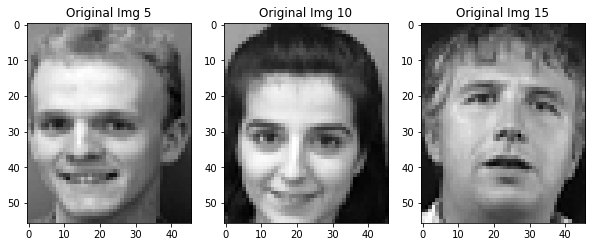

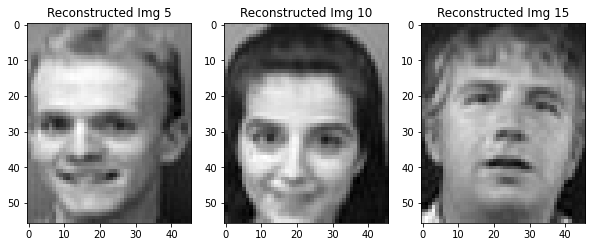

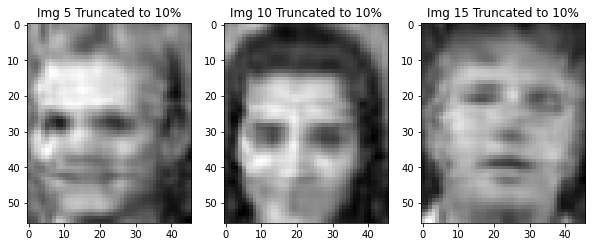

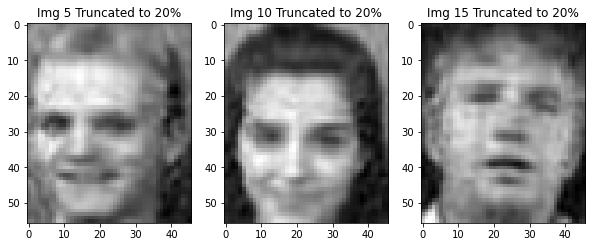

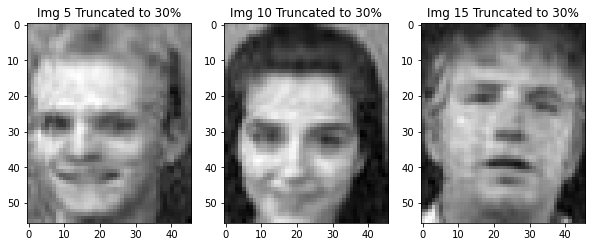

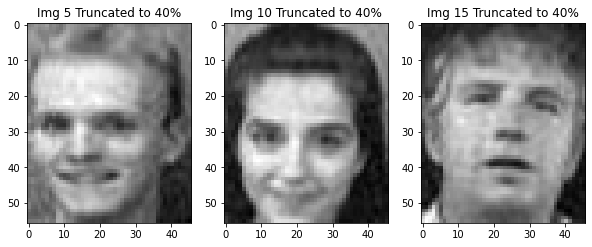

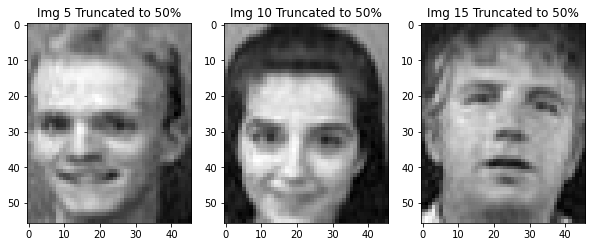

In [9]:
# Set up figure
fig = plt.figure(figsize=(10,10), frameon=False)
ax1 = fig.add_subplot(131)  
ax2 = fig.add_subplot(132)  
ax3 = fig.add_subplot(133)  
    
# Plot Original from Source
ax1.imshow(att[:,:,4],cmap='gray')
ax2.imshow(att[:,:,9], cmap='gray')
ax3.imshow(att[:,:,14],cmap='gray')

ax1.title.set_text('Original Img 5')
ax2.title.set_text('Original Img 10')
ax3.title.set_text('Original Img 15')

# Set up figure
fig = plt.figure(figsize=(10,10), frameon=False)
ax1 = fig.add_subplot(131)  
ax2 = fig.add_subplot(132)  
ax3 = fig.add_subplot(133)  
    
# Plot Original from Source
ax1.imshow(img_orig[:,:,4],cmap='gray')
ax2.imshow(img_orig[:,:,9], cmap='gray')
ax3.imshow(img_orig[:,:,14],cmap='gray')

ax1.title.set_text('Reconstructed Img 5')
ax2.title.set_text('Reconstructed Img 10')
ax3.title.set_text('Reconstructed Img 15')


# Hard Thresholding
for p in [0.1, 0.2, 0.3, 0.4, 0.5]: 
   
    # Initialize original core tensor
    G = core.copy()
    G_abs = abs(core)
    G_abs_1d = G_abs.reshape(-1, G_abs.shape[0]*G_abs.shape[1]*G_abs.shape[2])[0]

    # Find min of X% values
    num_recs = int(G_abs.shape[0]*G_abs.shape[1]*G_abs.shape[2]*p)
    min_index = np.argpartition(G_abs_1d, -num_recs)[-num_recs]
    min_val = G_abs_1d[min_index]
        
    # Get indexes of G_abs < 0
    zero_index = np.where(G_abs < min_val)

    # Set same indexs in G == 0 
    G[zero_index] = 0
    
    # Reconstruct A using new tensor
    A_recon = tl.tenalg.multi_mode_dot(G, [factors[0], factors[1], factors[2]], [0, 1, 2])
    
    # Set up figure
    fig = plt.figure(figsize=(10,10), frameon=False)
    ax1 = fig.add_subplot(131)  
    ax2 = fig.add_subplot(132)  
    ax3 = fig.add_subplot(133)  
    
    # Plot Images
    ax1.imshow(A_recon[:,:,4],cmap='gray')
    ax2.imshow(A_recon[:,:,9], cmap='gray')
    ax3.imshow(A_recon[:,:,14],cmap='gray')

    ax1.title.set_text('Img 5 Truncated to ' + str(int(p*100)) + '%')
    ax2.title.set_text('Img 10 Truncated to ' + str(int(p*100)) + '%')
    ax3.title.set_text('Img 15 Truncated to ' + str(int(p*100)) + '%')
    
    # Relative Error
    err = np.sqrt(norm(img_orig)**2-norm(A_recon)**2)/norm(img_orig)
    print('Relative Error (Reconstructed vs Truncated) for ' + str(int(p*100)) + '% Threshold = ' + str(round(err, 5)))
    
    err2 = np.sqrt(norm(att)**2-norm(A_recon)**2)/norm(att)
    print('Relative Error (Original vs Truncated) for ' + str(int(p*100)) + '% Threshold = ' + str(round(err2,5)))
    print('\n')